# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Данные находятся в трёх файлах:
* `gold_recovery_train_new.csv` — обучающая выборка;
* `gold_recovery_test_new.csv` — тестовая выборка;
* `gold_recovery_full_new.csv` — исходные данные.

Данные индексируются датой и временем получения информации (признак `date`). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

**Цель исследования:** — модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Ход исследования:**
1. Изучить общую информацию датафреймов
2. Подготовить данные для дальнейшей работы
3. Проанализировать данные
4. Провести обучение моделей с помощью кросс-валидации и выбрать лучшую, а затем проверить ее на тестовых данных

## Изучение общей информации

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor

### Открытие файлов

In [2]:
train_data = pd.read_csv('gold_recovery_train_new.csv', engine='python')
test_data = pd.read_csv('gold_recovery_test_new.csv', engine='python')
full_data = pd.read_csv('gold_recovery_full_new.csv', engine='python')

### Вывод первых десяти строк таблиц

In [3]:
train_data.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
test_data.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [5]:
full_data.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


### Вывод основной информации о датафреймах

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [8]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


### Проверка эффективности обогащения

Необходимо проверить, что эффективность обогащения рассчитана правильно. Используем формулу для расчета и сравним со значениями в таблице с помощью MAE.

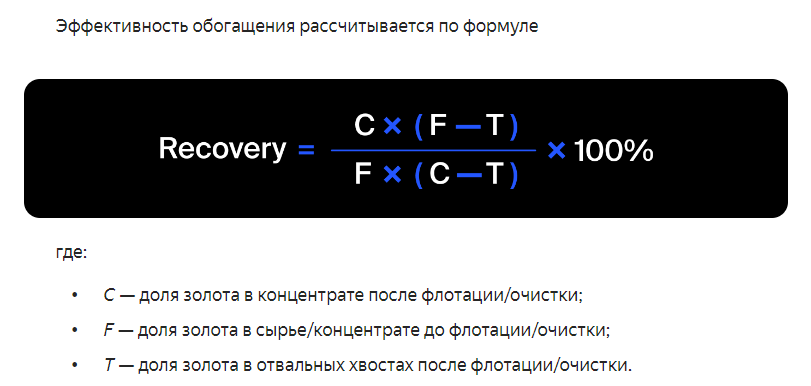

In [9]:
c = train_data['rougher.output.concentrate_au'] 
f = train_data['rougher.input.feed_au'] 
t = train_data['rougher.output.tail_au']

calculate_recovery = (c * (f - t)) / (f * (c - t)) * 100

mean_absolute_error(calculate_recovery, train_data['rougher.output.recovery'])

9.73512347450521e-15

Средняя абсолютная ошибка показала значение, близкое к нулю. Следовательно, эффективность обогащения в таблице рассчитана правильно.

### Вывод

Согласно к документации к данным, признаки в таблице имеют следующую форму записи: `[этап].[тип_параметра].[название_параметра]`.

Возможные значения для блока `[этап]`:
* `rougher` — флотация
* `primary_cleaner` — первичная очистка
* `secondary_cleaner` — вторичная очистка
* `final` — финальные характеристики

Возможные значения для блока `[тип_параметра]`:
* `input` — параметры сырья
* `output` — параметры продукта
* `state` — параметры, характеризующие текущее состояние этапа
* `calculation` — расчётные характеристики

Во всех трех датафреймах были замечены пропущенные значения, которые необходимо будет заполнить при подготовке данных, а также разделить данные на признаки и целевые признаки. 

## Подготовка данных

### Заполнение пропущенных значений

Заполним все пропущенные значения медианами по столбцам:

In [10]:
test_data = test_data.fillna(test_data.median())
train_data = train_data.fillna(train_data.median())
full_data = full_data.fillna(full_data.median())

C:\Users\150ho\AppData\Local\Temp\ipykernel_47660\1604215292.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_data = test_data.fillna(test_data.median())
C:\Users\150ho\AppData\Local\Temp\ipykernel_47660\1604215292.py:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_data = train_data.fillna(train_data.median())
C:\Users\150ho\AppData\Local\Temp\ipykernel_47660\1604215292.py:3: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addi

### Работа с обучающей и тестовой выборками

Так как в тестовой выборке нет тех признаков, которые есть в обучающей, то столбцы с этими признаками стоит удалить из обучающей выборки. Стоит отметить, что в тестовой выборке также нет целевых признаков `final.output.recovery` и `rougher.output.recovery`.

In [11]:
#выбираем столбцы, которых нет в тестовой выборке
data_diff = train_data.columns.difference(test_data.columns) 
#убираем целевые признаки, иначе они удалятся из обучающей выборки
data_diff = data_diff.drop(['final.output.recovery', 'rougher.output.recovery'])

In [12]:
train_data = train_data.drop(labels=data_diff, axis=1)
train_data.shape

(14149, 55)

Необходимо дозаполнить тестовую выборку целевыми признаками. С помощью `merge` сравниваем датафреймы `test_data` и `full_data` по дате (`date`) и находим необходимые значения целевых признаков.

In [13]:
test_data['final.output.recovery'] = pd.merge(test_data, full_data, on=['date'], how='outer')['final.output.recovery']
test_data['rougher.output.recovery'] = pd.merge(test_data, full_data, on=['date'], how='outer')['rougher.output.recovery']

Выделяем необходимые признаки для `features_train` и `features_test`, а также делим целевые признаки на два отдельных.

In [14]:
features_train = train_data.drop(['final.output.recovery', 'rougher.output.recovery', 'date'], axis=1)
target_train_final = train_data['final.output.recovery']
target_train_rougher = train_data['rougher.output.recovery']

features_test = test_data.drop(['final.output.recovery', 'rougher.output.recovery', 'date'], axis=1)
target_test_final = test_data['final.output.recovery']
target_test_rougher = test_data['rougher.output.recovery']

### Масштабирование признаков

In [15]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

### Вывод

В данном разделе была произведена подготовка данных: были заполнены пропущенные значения с помощью медианы, затем из обучающей выборки были убраны признаки, которых нет в тестовой выборке, целевые признаки тестовой выборки были заполнены с помощью исходных данных, а затем численные признаки были промасштабированы.

## Анализ данных

### Изменения концентрации металлов

Построим гистограммы, чтобы наглядно увидеть изменения концентрации металлов. Концентрация серебра (Ag):

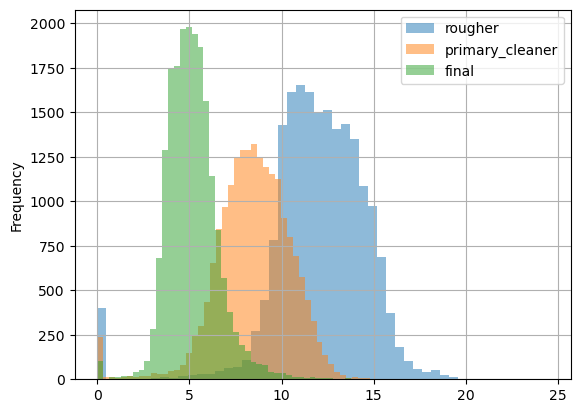

In [16]:
full_data['rougher.output.concentrate_ag'].plot(bins=50, kind='hist', alpha=0.5)
full_data['primary_cleaner.output.concentrate_ag'].plot(bins=50, kind='hist', alpha=0.5)
full_data['final.output.concentrate_ag'].plot(bins=50, kind='hist', grid=True, alpha=0.5)
plt.legend(['rougher', 'primary_cleaner', 'final'])

Учитывая, что сначала идет флотация (`rougher`), затем очистка (`primary_cleaner`) и после финальный концентрат (`final`), по данному графику можно сказать, что концентрация серебра с кадждым этапом уменьшалась.

Концентрация золота (Au):

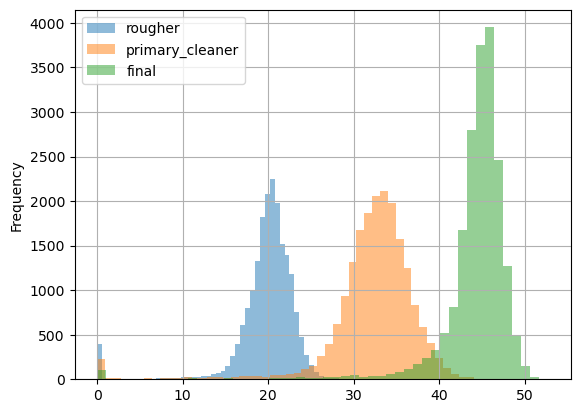

In [17]:
full_data['rougher.output.concentrate_au'].plot(bins=50, kind='hist', alpha=0.5)
full_data['primary_cleaner.output.concentrate_au'].plot(bins=50, kind='hist', alpha=0.5)
full_data['final.output.concentrate_au'].plot(bins=50, kind='hist', grid=True, alpha=0.5)
plt.legend(['rougher', 'primary_cleaner', 'final'])

На данном графике видно, что в финальном концентрате золота больше, чем при флотации и очистке, что логично, так как из руды восстанавливается именно золото.

Концентрация свинца (Pb):

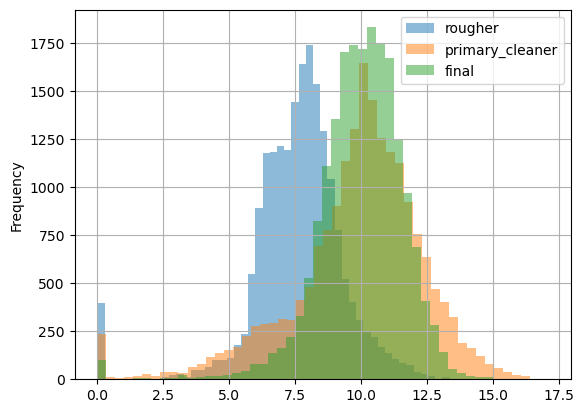

In [18]:
full_data['rougher.output.concentrate_pb'].plot(bins=50, kind='hist', alpha=0.5)
full_data['primary_cleaner.output.concentrate_pb'].plot(bins=50, kind='hist', alpha=0.5)
full_data['final.output.concentrate_pb'].plot(bins=50, kind='hist', grid=True, alpha=0.5)
plt.legend(['rougher', 'primary_cleaner', 'final'])

Концентрации свинца стало меньше в финальном концентрате, чем при флотации, но концентрация не особо изменилась после очистки.

### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

Нужно сравнить распределения размеров гранул сырья на обучающей и тестовой выборках, так как если распределения сильно отличаются друг от друга, то оценка модели будет неправильной.

Рассмотрим распределения разеров гранул сырья при флотации:

(0.0, 200.0, 0.0, 0.05)

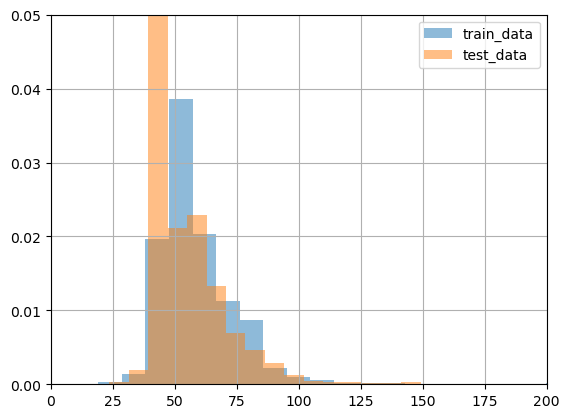

In [19]:
train_data['rougher.input.feed_size'].hist(bins=50, density=True, alpha=0.5)
test_data['rougher.input.feed_size'].hist(bins=50, density=True, alpha=0.5)
plt.legend(['train_data', 'test_data'])
plt.axis([0, 200, 0, 0.05])

Рассмотрим распределения разеров гранул сырья при очистке:

(4.0, 10.0, 0.0, 0.9)

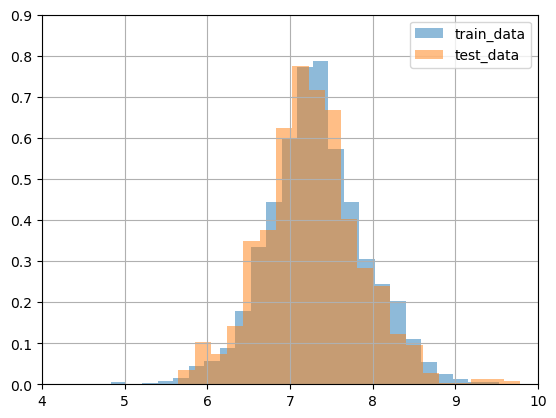

In [20]:
train_data['primary_cleaner.input.feed_size'].hist(bins=50, density=True, alpha=0.5)
test_data['primary_cleaner.input.feed_size'].hist(bins=50, density=True, alpha=0.5)
plt.legend(['train_data', 'test_data'])
plt.axis([4, 10, 0, 0.9])

По графикам видно, что при флотации распределения немного отличаются, но при очистке разница уже почти не заметна. Следовательно, оценка модели будет верна.

### Суммарная концентрацию всех веществ на разных стадиях

Рассмотрим концентрацию веществ на разных стадиях на исходной выборке:

In [21]:
rougher_input = (full_data['rougher.input.feed_au'] + #концентрация на входе флотации
                 full_data['rougher.input.feed_pb'] + 
                 full_data['rougher.input.feed_ag'] + 
                 full_data['rougher.input.feed_sol'])

rougher_output = (full_data['rougher.output.concentrate_au'] + #концентрация на выходе флотации 
                  full_data['rougher.output.concentrate_ag'] +
                  full_data['rougher.output.concentrate_pb'] +
                  full_data['rougher.output.concentrate_sol'])

final_output = (full_data['final.output.concentrate_au'] + #концентрация веществ в финальном концентрате
                full_data['final.output.concentrate_ag'] +
                full_data['final.output.concentrate_pb'] +
                full_data['final.output.concentrate_sol'])

Визуализируем суммарные концентрации с помощью гистограмм:

<AxesSubplot:>

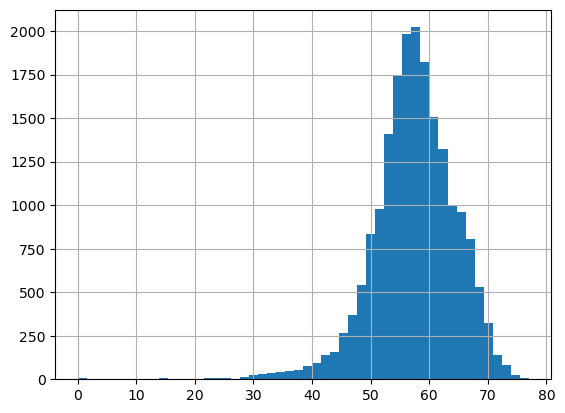

In [22]:
rougher_input.hist(bins=50)

<AxesSubplot:>

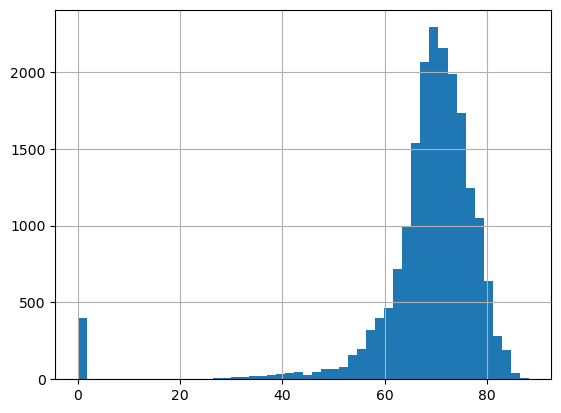

In [23]:
rougher_output.hist(bins=50)

<AxesSubplot:>

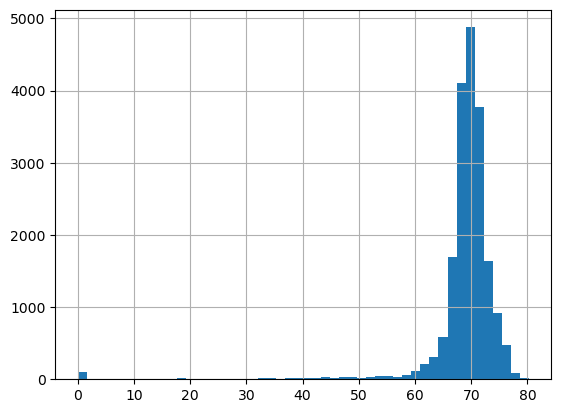

In [24]:
final_output.hist(bins=50)

Заметим, что в некоторых случаях суммарная концентрация равна 0, чего точно быть не может. Необходимо данные объекты удалить из исходной, тренировочной и тестовой выборок.

In [25]:
full_data = full_data.loc[((full_data['final.output.concentrate_au'] +
                           full_data['final.output.concentrate_ag'] +
                           full_data['final.output.concentrate_pb'] +
                           full_data['final.output.concentrate_sol']) != 0) &
                          ((full_data['rougher.output.concentrate_au'] +
                           full_data['rougher.output.concentrate_ag'] +
                           full_data['rougher.output.concentrate_pb'] +
                           full_data['rougher.output.concentrate_sol']) != 0) &
                          ((full_data['rougher.input.feed_au'] + 
                           full_data['rougher.input.feed_pb'] + 
                           full_data['rougher.input.feed_ag'] + 
                           full_data['rougher.input.feed_sol']) != 0)]

train_data = train_data.loc[((train_data['rougher.input.feed_au'] + 
                           train_data['rougher.input.feed_pb'] + 
                           train_data['rougher.input.feed_ag'] + 
                           train_data['rougher.input.feed_sol']) != 0)]

test_data = test_data.loc[((test_data['rougher.input.feed_au'] + 
                           test_data['rougher.input.feed_pb'] + 
                           test_data['rougher.input.feed_ag'] + 
                           test_data['rougher.input.feed_sol']) != 0)]

### Вывод

Были проанализированы изменения концентрации металлов: от флотации и до финального концентрата количество золота увеличивалось, а серебра и свинца уменьшалось (как и должно быть). 

Для более точной работы модели были исследованы распределения гранул сырья на обучающей и тестовой выборке. Распределения отличаются слабо, поэтому оценка модели будет верна.

При суммарной концентрации всех веществ на разных стадиях были замечены суммарные концентрации, равные нулю, чего быть не может, вследствии чего данные объекты были удалены.

## Модель

### Функция для вычисления sMAPE

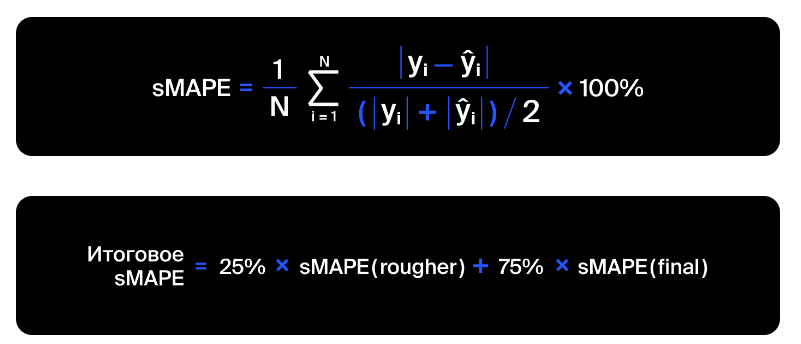

In [26]:
def smape(target, predictions):
    smape_score =  1 / len(target) * (abs(target - predictions) / ((abs(target) + abs(predictions)) / 2)).sum()
    return smape_score

### Выбор лучшей модели случайного леса

Сделаем скорер из нашей функции, определяющей smape:

In [27]:
smape_score = make_scorer(smape, greater_is_better=False)

Затем с помощью `GridSearchCV` обучим разные модели и оценим их качество кросс-валидацией. 

In [28]:
model_rougher = RandomForestRegressor(random_state=12345) #модель для целевого признака rougher

params = {'n_estimators' : range(1, 10, 1),
             'max_depth' : range(1, 10, 1)}

grid_rougher = GridSearchCV(model_rougher, params, scoring=smape_score, cv=3)
grid_rougher.fit(features_train, target_train_rougher)

model_rougher = grid_rougher.best_estimator_

print(model_rougher)

RandomForestRegressor(max_depth=6, n_estimators=9, random_state=12345)


In [29]:
model_final = RandomForestRegressor(random_state=12345) #модель для целевого признака final

grid_final = GridSearchCV(model_rougher, params, scoring=smape_score, cv=3)
grid_final.fit(features_train, target_train_final)

model_final = grid_final.best_estimator_

print(model_final)

RandomForestRegressor(max_depth=2, n_estimators=9, random_state=12345)


Теперь можем вычислить итоговое значение sMAPE:

In [30]:
rougher_smape = smape(target_train_rougher, model_rougher.predict(features_train))
final_smape = smape(target_train_final, model_final.predict(features_train))

final_smape_score = 0.25 * rougher_smape + 0.75 * final_smape

print(final_smape_score)

0.09545264644504686


Для данной модели итоговое sMAPE равно 9.5%.

### Проверка линейной регрессии по sMAPE

Далее с помощью того же скорера и `cross_val_score` исследуем линейную регрессию.

In [31]:
model_reg = LinearRegression()

scores_rougher = cross_val_score(model_reg, features_train, target_train_rougher, scoring=smape_score)
scores_final = cross_val_score(model_reg, features_train, target_train_final, scoring=smape_score)

final_smape_score = (-0.25) * scores_rougher + (-0.75) * scores_final

print(final_smape_score)

[0.14766462 0.11056422 0.1203485  0.11973153 0.13453272]


Для любой из обученных с помощью кросс-валидации моделей линейной регрессии итогове sMAPE оказалось хуже, чем для лучшей модели случайного леса: значения итогового sMAPE не ниже 11%. Следовательно, лучшей моделью выбираем лучшую модель случайного леса.

### Проверка лучшей модели на тестовой выборке

In [32]:
best_rougher_score = smape(target_test_rougher, model_rougher.predict(features_test))
best_final_score = smape(target_test_final, model_final.predict(features_test))

best_smape_score = 0.25 * best_rougher_score + 0.75 * best_final_score

print(best_smape_score)

0.09504521556984935


### Дамми проверка

In [33]:
dummy_clf = DummyRegressor(strategy='mean')
dummy_clf.fit(features_train, target_train_rougher)
dummy_rougher_score = smape(target_test_rougher, dummy_clf.predict(features_test))

dummy_clf.fit(features_train, target_train_final)
dummy_final_score = smape(target_test_final, dummy_clf.predict(features_test))

final_dummy_smape = 0.25 * dummy_rougher_score + 0.75 * dummy_final_score

print('Значение итогового sMAPE для dummy модели регрессии', final_dummy_smape)

Значение итогового sMAPE для dummy модели регрессии 0.10289630376021036


### Вывод

Функция нахождения sMAPE была сделана скорером, с помощью которого была проведена кросс-валидация моделей случайного леса и линейной регрессии. По значениям итогового sMAPE была выбрана лучшей моделью модель случайного леса. На тестовой выборке данная модель показала значение итогового sMAPE, равное 9.5%. Дамми проверка же показала значение итогового sMAPE, равное 10%.

## Вывод

Данные датафреймов были изучены и подготовлены к работе с моделями. На этапе изучения была проведена проверка эффективности обогащения, которая показала, что эффективность обогащения в данных была высчитана верно. Также было замечено отсутствие данных в некоторых столбцах.

При подготовке данных пропущенные значения были заполнены медианами. Отсутствующие в тестовой выборке столбцы были также удалены и из обучающей выборки, а из-за отсутствия в тестовой выборке целевых признаков их необходимо было взять из датафрейма с исходными данными и сравнить объекты по дате. Также понадобилось промасштабировать численные признаки.

При анализе данных было установлено, как изменяются концентрации металлов в разных этапах. Концентрация золота увеличивалась, а концентрации серебра и свинца уменьшались. Суммарная концентрация веществ на некоторых этапах была равна нулю, что недопустимо, в связи с чем такие объекты были удалены. 

Для корректной работы модели было проведено сравнение распределений гранул сырья на обучающей и тестовой выборках. Распределения отличаются слабо, следовательно, оценка модели будет верна.

Для выбора лучшей модели были использованы модели случайного леса с перебором параметров и модель линейной регрессии. Для оценки была использована кросс-валидация с функцией sMAPE в качестве скорера. Самый лучший результат показала модель случайного леса — ее значение sMAPE равно 9.5%. При проверке данной модели на тестовой выборке симметричное среднее абсолютное процентное отклонение равно 9.5%, что меньше, чем у дамми модели — 10%.